In [ ]:
import torch as t
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import seaborn as sns

from analysis_utils import get_models_from
from utils.data import SimpleTokenizer

In [4]:
# exp results
RESULTS_DIR = "experiment_results/"

# exp results
all_sweeps_df = pd.read_csv(RESULTS_DIR + 'all_sweeps_df.csv')

# get indist and ood datasets
INDIST_PATH = RESULTS_DIR + "indist_data_preds.csv"
OOD_PATH = RESULTS_DIR + "ood_data_preds.csv"

In [5]:
def most_impactful_head(ablated_row, layer, checkpoint, by_ood=True):
    ood_or_indist = "ood" if by_ood else "indist"
    original_acc = ablated_row[f'cp{checkpoint}_{ood_or_indist}_acc']
    most_impactful_head = 1
    max_diff = 0
    for head in range(1, 5):
        key = f"l{layer}_h{head}_{ood_or_indist}"
        key = f"cp{checkpoint}_{key}"
        if key in ablated_row:
            if ablated_row[key] != -1:
                diff = ablated_row[key] - original_acc
                if abs(diff) > abs(max_diff):
                    max_diff = diff
                    most_impactful_head = head
    key = f"layer_{layer}_head_{most_impactful_head}"
    return key, max_diff

def max_head_score(row, head_type, layer, checkpoint, indist_or_ood):
    return max([row[f"cp{checkpoint}_{head_type}_head_l{layer}_h{head_num}_{indist_or_ood}"] for head_num in [1,2,3,4]])

def has_head_type(row, head_type, layer, checkpoint, threshold=0.5, indist_or_ood='ood'):
    return max_head_score(row, head_type, layer, checkpoint, indist_or_ood) >= threshold

names = {'open': 'Open-Bracket Attention Head', 'close': 'Close-Bracket Attention Head',
             'nonneg': 'Nonnegative Depth Attention Head', 'neg': 'Negative Depth Attention Head',
             'sign': 'Depth Sign Attention Head', 'ambi': 'Ambivalent Depth Attention Head',}

names_short = {'open': 'Open-Bracket', 'close': 'Close-Bracket', 'nonneg': 'Nonneg. Depth', 'neg': 'Neg. Depth',
               'none of the above': 'None of the Above', 'both open and close': 'Both Open and Close',
                'both nonneg and neg': 'Both Nonneg. and Neg.', 'sign': 'Sign', 'ambi': 'Ambi-Depth'}

def extend(head_type_ls):
    if len(head_type_ls) == 2 and 'open' in head_type_ls and 'close' in head_type_ls:
        return head_type_ls + ['both open and close', 'none of the above']
    elif len(head_type_ls) == 2 and 'nonneg' in head_type_ls and 'neg' in head_type_ls:
        return head_type_ls + ['both nonneg and neg', 'none of the above']
    else:
        return head_type_ls + ['both open and close', 'both nonneg and neg', 'none of the above']

In [6]:
def hex_code_averager(hex1, hex2, weight1=0.5):
        r1, g1, b1 = int(hex1[1:3], 16), int(hex1[3:5], 16), int(hex1[5:], 16)
        r2, g2, b2 = int(hex2[1:3], 16), int(hex2[3:5], 16), int(hex2[5:], 16)
        r_avg = int(r1*weight1 + r2*(1-weight1))
        g_avg = int(g1*weight1 + g2*(1-weight1))
        b_avg = int(b1*weight1 + b2*(1-weight1))
        # return averaged hex code
        return f"#{r_avg:02x}{g_avg:02x}{b_avg:02x}"

def get_depth_color_scheme():
    
    gray = '#999999'
    red = '#FF0000'
    blue = '#0000FF'
    
    return  {
        'TrueFalse': {'color': hex_code_averager(red, gray), 'index': 1, 'label': names["neg"]},
        'FalseTrue': {'color': hex_code_averager(gray, blue), 'index': 0, 'label': names["nonneg"]},
        'TrueTrue': {'color': hex_code_averager(red, blue), 'index': 2, 'label': 'Both'},
        'FalseFalse': {'color': gray, 'index': 3, 'label': 'Neither'}
    }, ("neg", "nonneg")

def get_count_color_scheme():
    
    gray = '#999999'
    green = '#00FF00'
    orange = '#FFA500'
    yellow = '#FFFF00'
    
    return  {
        'TrueFalse': {'color': hex_code_averager(orange, gray, 0.8), 'index': 1, 'label': names["open"]},
        'FalseTrue': {'color': hex_code_averager(gray, green), 'index': 0, 'label': names["close"]},
        'TrueTrue': {'color': hex_code_averager(yellow, gray, 0.8), 'index': 2, 'label': 'Both'},
        'FalseFalse': {'color': gray, 'index': 3, 'label': 'Neither'}
    }, ("open", "close")

def get_color_for(key, text=False):
    count_colors, count_keys = get_count_color_scheme()
    depth_colors, depth_keys = get_depth_color_scheme()
    sign_color = '#007700'
    contains = lambda keys, key : str(keys[0] in key and keys[1] != key) + str(keys[1] in key and keys[0] != key)
    if 'sign' in key:
        color = sign_color
    elif count_keys[0] in key or count_keys[1] in key:
        color = count_colors[contains(count_keys, key)]['color']
    else:
        color = depth_colors[contains(depth_keys, key)]['color'] 
    return color if not text else hex_code_averager(color, '#000000', 0.8) # mix with black ish

dict_keys(['p2chsvxk', 'yor640k7', 'sekevna7', 'jd230b4h'])
p2chsvxk
yor640k7
sekevna7
jd230b4h


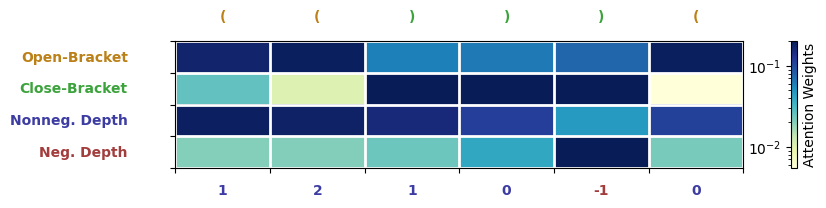

In [6]:
def specific_row_attention_examples(runs_df, tokens_as_string, head_types = ['open', 'close', 'nonneg', 'neg']):
    models = get_models_from(runs_df)

    print(models.keys())

    not_shown = []

    tokenizer = SimpleTokenizer(alphabet='()')
    tokens = tokenizer.tokenize(tokens_as_string)[0]
    
    # Create a mask for non-pad tokens
    mask = tokens != 1  # Assuming 1 is the pad token
    non_pad_indices = mask.nonzero().squeeze()
    
    # Get labels (excluding pad tokens)
    labels = [tokenizer.i_to_t[int(x)] for x in list(tokens) if int(x) != 1]
    labels = labels[1:-1]
    
    # Prepare data for heatmap
    heatmap_data = []
    model_labels = []
    text_colors = []
    cp5_ood_acc_data = []
    for i, (_, row) in enumerate(runs_df.iterrows()):
        layer = row['n_layer']
        
        run_id = row['id']
        model = models[run_id]
        max_diff = -1
        
        model.eval()
        with t.no_grad():
            if t.cuda.is_available():
                tokens = tokens.cuda()
            _ = model(tokens.unsqueeze(0))
            attention_weights = model.get_attention_weights()

        # Determine which attention weights to visualize
        key, max_diff = most_impactful_head(row, layer, checkpoint=5)
        if run_id == "p2chsvxk":
            key = key[:-1] + "1"
        if max_diff == 0:
            not_shown.append((run_id, layer, row[f'cp5_ood_acc']))
            continue
        selected_token_attn = attention_weights[key][non_pad_indices][-1]

        # mask out the pad tokens
        selected_token_attn = selected_token_attn[non_pad_indices][1:-1]

        heatmap_data.append(selected_token_attn.cpu().numpy())
        
        head = int(key.split("head_")[1])
        print(run_id)
        head_type_description = ""
        for head_type in head_types:
            if row[f"cp5_{head_type}_head_l{layer}_h{head}_ood"] >= 0.5:
                head_type_description += head_type
        
        model_labels.append(f"{names_short[head_type_description]}")
        text_colors.append(get_color_for(head_type_description, text=True))
        cp5_ood_acc_data.append(row['cp5_ood_acc'])
        
    if len(not_shown) == len(runs_df):

        print(f"No causal effect in any model of any attention head in layer {layer} on ood acc")
        print("The models' ood accs were: " + ", ".join([f"{acc}" for run_id, layer, acc in not_shown]))
        return

    # Create heatmap
    fig, ax = plt.subplots(figsize=(10, len(heatmap_data)*0.6))

    # Convert heatmap_data to a numpy array
    heatmap_data = np.array(heatmap_data)
    
    # Apply logarithmic normalization for the main heatmap
    norm_main = LogNorm(vmin=max(heatmap_data.min(), 1e-3), vmax=min(heatmap_data.max(), 0.2))

    
    # Plot main heatmap
    im_main = ax.imshow(heatmap_data, cmap='YlGnBu', norm=norm_main, aspect='auto')
    
    # Set tick labels
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(model_labels)))
    ax.set_xticklabels(labels, rotation=0, ha='right')
    ax.set_yticklabels(model_labels)

    # Add colorbars
    cbar_main = plt.colorbar(im_main, ax=ax, fraction=0.046, pad=0.06, label='Attention Weights')

    # Adjust colorbar positions to prevent overlap
    cbar_main.ax.yaxis.set_ticks_position('left')
    
    # Add grid to visually separate tokens
    ax.set_xticks(np.arange(len(labels)+1)-.5, minor=False)
    ax.set_yticks(np.arange(len(model_labels)+1)-.5, minor=False)

    # Add grid lines
    ax.grid(which='major', color='w', linestyle='-', linewidth=2)

    # label rows
    for i, label in enumerate(model_labels):
        ax.text(-1, i, label, ha='right', va='center', color=text_colors[i], fontweight='bold')
    
    depth = 0
    depths = []
    for char in labels:
        if char == "(":
            depth += 1
            depths.append(depth)
        elif char == ")":
            depth -= 1
            depths.append(depth)
        else:
            depths.append(0)
    # label columns
    for i, label in enumerate(labels):
        if label == '(':
            color = get_color_for("open", text=True)
        else:
            color = get_color_for("close", text=True)
        ax.text(i, -1.5, label, ha='center', va='top', color=color, fontweight='bold')

    for i, depth in enumerate(depths):
        if depth >= 0:
            color = get_color_for("nonneg", text=True)
        else:
            color = get_color_for("neg", text=True)
        ax.text(i, 4, depth, ha='center', va='top', color=color, fontweight='bold')    



    # # Set title
    # fig.suptitle(f'Activations at EOS for Example Attention Heads', fontsize=16)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Adjust the position of the main axes to make room for the new columns
    box = ax.get_position()
    ax.set_position([box.x0 + box.width * 0.2, box.y0, box.width * 0.8, box.height])
    
    plt.show()

    if len(not_shown) > 0:
        print(f"{len(not_shown)} models did not show any causal effect of any attention head in layer {layer} on ood acc")
        print("Their ood accs were: " + ", ".join([f"{acc}" for run_id, layer, acc in not_shown]))
    


mini_df = all_sweeps_df[all_sweeps_df['id'].isin(['p2chsvxk',  'jd230b4h', 'yor640k7', 'sekevna7'])]

# sort in order of ['jd230b4h', 'sekevna7', 'bpeprx1a', 'p2chsvxk']
mini_df = mini_df.iloc[[0, 1, 2, 3]]
mini_df['id']
specific_row_attention_examples(mini_df, "(()))(")

In [23]:
# Create a copy of the original DataFrame
new_sweeps_df = all_sweeps_df.copy()

# Identify columns that contain the substrings "head" and "indist"
columns_to_modify = [col for col in new_sweeps_df.columns if "head" in col]

# Replace entries of the form "[]" with the float 0.0 in the identified columns
for col in columns_to_modify:
    new_sweeps_df[col] = new_sweeps_df[col].apply(lambda x: 0.0 if x == "[]" else float(x))

# Display the modified DataFrame
new_sweeps_df.head()

,Unnamed: 0,id,name,lr,wd,opt,batch_size,rdm_seed,shuffle_seed,n_layer,...,cp5_sign_head_l1_h3_ood,cp5_sign_head_l1_h4_ood,cp5_sign_head_l2_h1_ood,cp5_sign_head_l2_h2_ood,cp5_sign_head_l2_h3_ood,cp5_sign_head_l2_h4_ood,cp5_sign_head_l3_h1_ood,cp5_sign_head_l3_h2_ood,cp5_sign_head_l3_h3_ood,cp5_sign_head_l3_h4_ood
0,270,zbxb7y9g,honest-sweep-271,0.0001,0.010,adam,8,365,161,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,271,8ihgvt2l,fluent-sweep-272,0.0001,0.001,adam,8,365,161,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,272,ypzdbh43,genial-sweep-273,0.0001,0.000,adam,8,365,161,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,273,yhytiuc6,honest-sweep-274,0.0001,0.010,adam,8,365,231,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,274,ovoo94zl,tough-sweep-275,0.0001,0.001,adam,8,365,231,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
for col in new_sweeps_df.columns:
    if "sign_head" in col:
        for val in new_sweeps_df[col]:
            if val > 0.5:
                print(col)
                break

cp5_sign_head_l2_h1_indist
cp5_sign_head_l2_h2_indist
cp5_sign_head_l2_h3_indist
cp5_sign_head_l2_h4_indist
cp5_sign_head_l3_h1_indist
cp5_sign_head_l3_h2_indist
cp5_sign_head_l3_h3_indist
cp5_sign_head_l3_h4_indist
cp5_sign_head_l2_h1_ood
cp5_sign_head_l2_h2_ood
cp5_sign_head_l2_h3_ood
cp5_sign_head_l2_h4_ood
cp5_sign_head_l3_h1_ood
cp5_sign_head_l3_h2_ood
cp5_sign_head_l3_h3_ood
cp5_sign_head_l3_h4_ood


In [15]:
for x in all_sweeps_df.columns:
    if "sign_head" in x:
        for elt in all_sweeps_df[x]:
            if type(elt) == str:
                print(x)
                print(elt)
                break


cp5_sign_head_l1_h3_indist
[]
cp5_sign_head_l1_h4_indist
[]
cp5_sign_head_l2_h1_indist
[]
cp5_sign_head_l2_h2_indist
[]
cp5_sign_head_l2_h3_indist
[]
cp5_sign_head_l2_h4_indist
[]
cp5_sign_head_l3_h1_indist
[]
cp5_sign_head_l3_h2_indist
[]
cp5_sign_head_l3_h3_indist
[]
cp5_sign_head_l3_h4_indist
[]
cp5_sign_head_l1_h3_ood
[]
cp5_sign_head_l1_h4_ood
[]
cp5_sign_head_l2_h1_ood
[]
cp5_sign_head_l2_h2_ood
[]
cp5_sign_head_l2_h3_ood
[]
cp5_sign_head_l2_h4_ood
[]
cp5_sign_head_l3_h1_ood
[]
cp5_sign_head_l3_h2_ood
[]
cp5_sign_head_l3_h3_ood
[]
cp5_sign_head_l3_h4_ood
[]


ambi


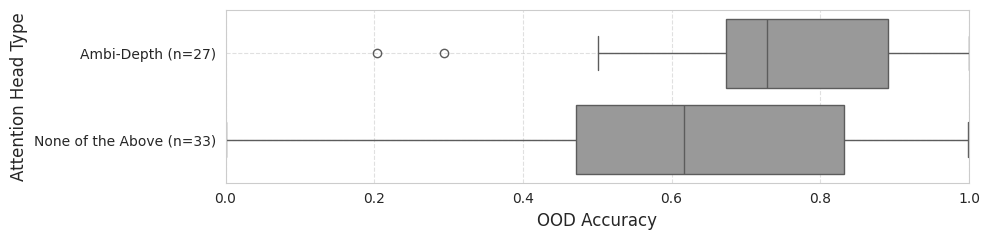

ambi


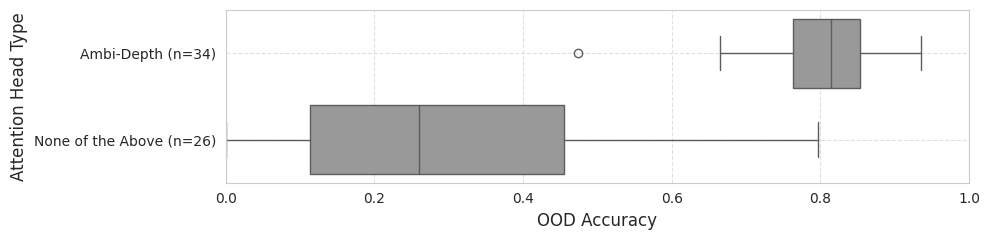

ambi


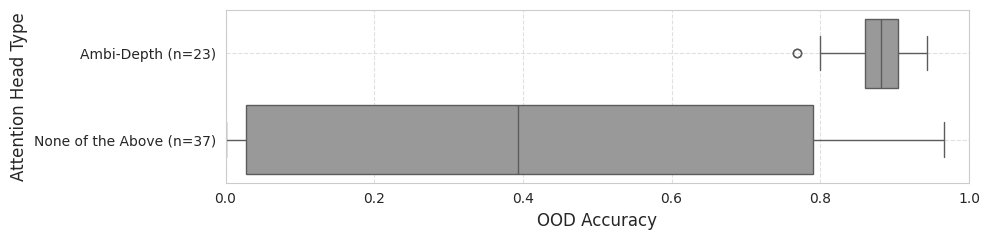

In [21]:
def box_plot(runs_df,title="Distribution of Attention Head Scores", x_labels=[], depth_only=False, count_only = False,
                include_weak_heads=False, head_types = ['open', 'close', 'nonneg', 'neg', 'sign'], default_threshold=0.5):
    # Prepare data for plotting
    plot_data = []
    for i, row in runs_df.iterrows():
        head_found = False
        ood_acc = row[f'cp5_ood_acc']

        head_types = ['nonneg', 'neg'] if depth_only else ['open', 'close'] if count_only else head_types
        for head_type in head_types:
            # input 'ood' below to get the original box plot
            if has_head_type(row, head_type, row['n_layer'], checkpoint=5, threshold=default_threshold, indist_or_ood='indist'):
                plot_data.append({'Value': names_short[head_type], 'OOD Acc': ood_acc, 'Condition': head_type})
                head_found = True

        if not head_found:
            if include_weak_heads:
                for head_type in head_types:
                    if has_head_type(row, head_type, row['n_layer'], checkpoint=5, threshold=0.25):
                        ood_acc = row[f'cp5_ood_acc']
                        plot_data.append({'Value': 'Weak ' + names_short[head_type], 'OOD Acc': ood_acc, 'Condition': 'weak' + head_type})
                        head_found = True
            if not head_found:
                value = 'None of the Above' if include_weak_heads or not (depth_only or count_only) else 'Neither'

                plot_data.append({'Value': value, 'OOD Acc': ood_acc, 'Condition': 'none of the above'})

    df = pd.DataFrame(plot_data)
    if not len(x_labels):
        x_labels = df['Value'].unique()
    # Sort the dataframe by x_labels order
    df = df.sort_values('Value', key = lambda x: x.map(lambda val: x_labels.index(val)))

    # add the number of models in each category to its x_label
    # and change the name in the dataframe as well
    for x_label in x_labels:
        n_models = len(df[df['Value'] == x_label])
        x_labels[x_labels.index(x_label)] = f"{x_label} (n={n_models})"
        df.loc[df['Value'] == x_label, 'Value'] = f"{x_label} (n={n_models})"

    

    # Set up the plot
    plt.figure(figsize=(10, 2.5))
    sns.set_style("whitegrid")

    # Define custom color palette
    color_palette = {key: get_color_for(key) for key in head_types + ['none of the above']}
    for key in head_types:
        print(key)
        color_palette['weak' + key] = hex_code_averager(get_color_for(key), get_color_for('none of the above'))
    
    # Create the violin plots
    sns.boxplot(x='OOD Acc', y='Value', hue='Condition', data=df, orient='h', order=x_labels, palette=color_palette)
                #    inner="quartile", cut=0, bw_method=.2,
                #    palette=color_palette, order = x_labels, orient='h', density_norm='count')

    # Customize the plot
    plt.title(title, fontsize=16)
    plt.ylabel('Attention Head Type', fontsize=12)
    plt.xlabel('OOD Accuracy', fontsize=12)

    plt.xlim(0, 1)
    # Rename x-axis labels
    plt.yticks(range(len(x_labels)), x_labels)
    # Add a subtle grid
    plt.grid(True, linestyle='--', alpha=0.6)

    # DELETE LEGEND
    plt.legend().remove()

    plt.tight_layout()
    plt.show()

df = all_sweeps_df[all_sweeps_df['n_layer'] != 1]
df_wd0 = df[df['wd'] == 0]
df_wd1 = df[df['wd'] == 0.001]
df_wd2 = df[df['wd'] == 0.01]
# df = df[df['wd'] == 0]
# box_plot(df, title="", depth_only=True,
#             x_labels = ["Neg. Depth", "Nonneg. Depth", "Neither"])
# box_plot(df, title="", x_labels = ["Neg. Depth", "Nonneg. Depth", "Sign", "None of the Above"],
#             head_types = ['neg', 'nonneg', 'sign'], default_threshold=0.9)
# # box_plot(df, title="", x_labels = ["Sign", "None of the Above"],
# #             head_types = ['sign'])
# box_plot(df, title="", x_labels = ["Ambi-Depth", "None of the Above"],
#             head_types = ['ambi'], default_threshold=0.8)
box_plot(df_wd0, title="", x_labels = ["Ambi-Depth", "None of the Above"],
            head_types = ['ambi'], default_threshold=0.8)
box_plot(df_wd1, title="", x_labels = ["Ambi-Depth", "None of the Above"],
            head_types = ['ambi'], default_threshold=0.8)
box_plot(df_wd2, title="", x_labels = ["Ambi-Depth", "None of the Above"],
            head_types = ['ambi'], default_threshold=0.8)

In [11]:
new_sweeps_df = all_sweeps_df.copy()
for col in all_sweeps_df.columns:
    if "nonneg_head" in col:
        other_col = col.replace("nonneg", "neg")
        ambi_col_name = col.replace("nonneg", "ambi")
        new_sweeps_df[ambi_col_name] = all_sweeps_df[col] + all_sweeps_df[other_col]

new_sweeps_df['cp5_ambi_head_l3_h1_ood']

0      0.000
1      0.000
2      0.000
3      0.000
4      0.000
       ...  
265    0.000
266    0.528
267    0.000
268    0.000
269    0.249
Name: cp5_ambi_head_l3_h1_ood, Length: 270, dtype: float64

In [12]:
new_sweeps_df.to_csv(RESULTS_DIR + 'new_sweeps_df.csv', index=False)

In [13]:
all_sweeps_df = new_sweeps_df

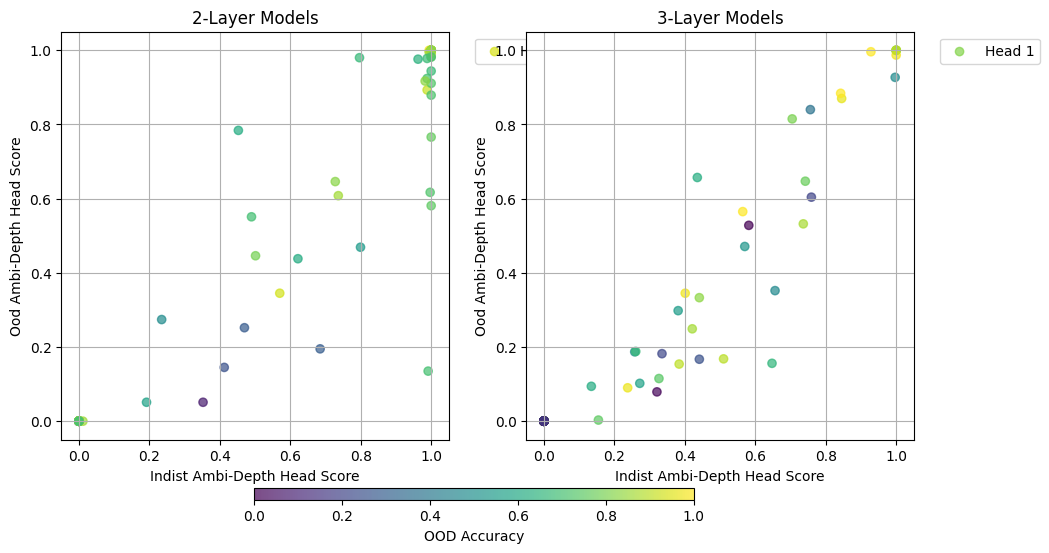

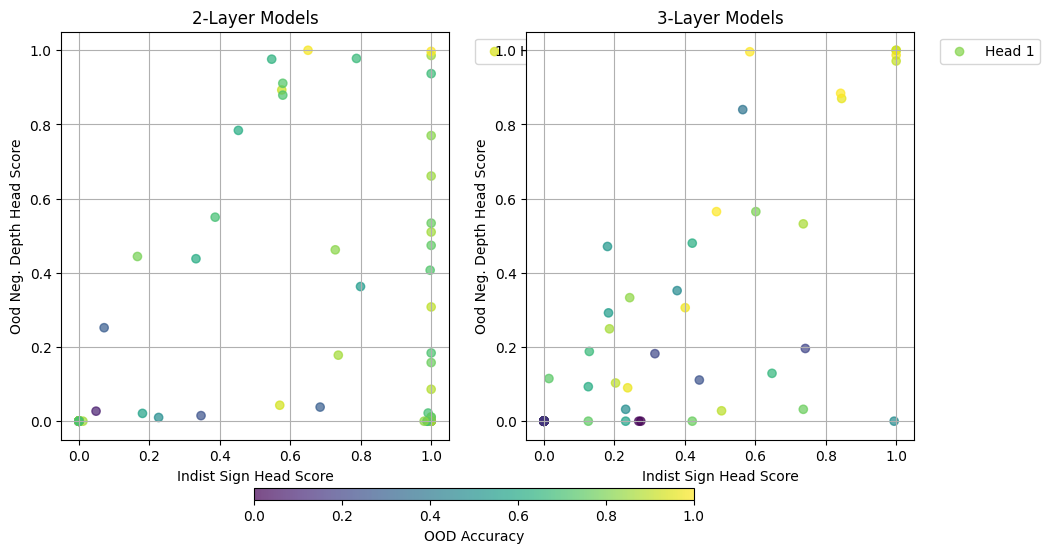

In [6]:
def scatter_plot_all_heads(df, head_type, x_dist='indist', y_dist='ood'):
    """
    Create scatter plots for all heads in the final layer of 2-layer and 3-layer models.
    
    Args:
        df: DataFrame containing the model data
        head_type: Either a string for same type on both axes (e.g., 'sign') or 
                  a tuple of two strings (e.g., ('sign', 'neg')) for different types
        x_dist: Distribution type for x-axis ('indist' or 'ood')
        y_dist: Distribution type for y-axis ('indist' or 'ood')
    """
    # Handle head_type input
    if isinstance(head_type, str):
        x_head_type = y_head_type = head_type
    elif isinstance(head_type, (tuple, list)) and len(head_type) == 2:
        x_head_type, y_head_type = head_type
    else:
        raise ValueError("head_type must be a string or a tuple/list of two strings")
        
    # Create figure with subplots, leaving space at bottom for colorbar
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6))
    
    # Process each layer type
    for layer_num, ax in [(2, ax1), (3, ax2)]:
        df_layer = df[df['n_layer'] == layer_num]
        
        if len(df_layer) == 0:
            continue
            
        # Get number of heads in the final layer
        n_heads = df_layer['n_head'].iloc[0]
        
        # Create scatter plot for each head
        for head_idx in range(n_heads):
            x_col = f'cp5_{x_head_type}_head_l{layer_num}_h{head_idx}_{x_dist}'
            y_col = f'cp5_{y_head_type}_head_l{layer_num}_h{head_idx}_{y_dist}'
            
            if x_col not in df_layer.columns or y_col not in df_layer.columns:
                continue
                
            scatter = ax.scatter(df_layer[x_col], 
                               df_layer[y_col],
                               c=df_layer['cp5_ood_acc'], 
                               cmap='viridis',
                               alpha=0.7,
                               label=f'Head {head_idx}')
        
        # Customize plot
        x_head_type_name = names_short[x_head_type]
        y_head_type_name = names_short[y_head_type]
        ax.set_title(f'{layer_num}-Layer Models')
        ax.set_xlabel(f'{x_dist.capitalize()} {x_head_type_name} Head Score')
        ax.set_ylabel(f'{y_dist.capitalize()} {y_head_type_name} Head Score')
        ax.grid(True, which="both", ls="-")
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
    # Adjust the main subplot layout to leave space for colorbar
    plt.subplots_adjust(bottom=0.2)
    
    # Add smaller colorbar at the bottom
    cbar_ax = fig.add_axes([0.3, 0.1, 0.4, 0.02])  # [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('OOD Accuracy')
    
    plt.show()

# Example usage:
# Original usage still works
scatter_plot_all_heads(all_sweeps_df, 'ambi')

# New usage with different head types
scatter_plot_all_heads(all_sweeps_df, ('sign', 'neg'), x_dist = 'indist', y_dist='ood')  # Sign heads vs Neg heads

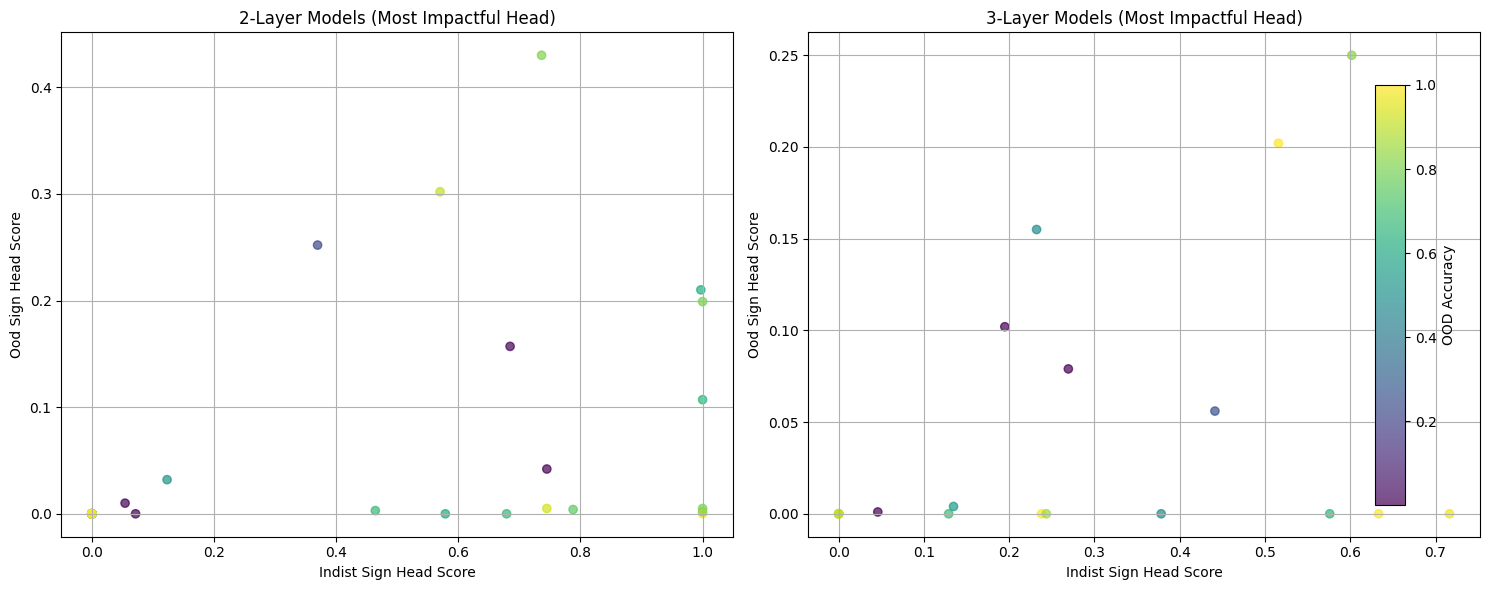

In [7]:
def scatter_plot_most_impactful_head(df, head_type, x_dist='indist', y_dist='ood'):
    """
    Create scatter plots for only the most impactful head in the final layer of 2-layer and 3-layer models.
    """
    # Handle head_type input
    if isinstance(head_type, str):
        x_head_type = y_head_type = head_type
    elif isinstance(head_type, (tuple, list)) and len(head_type) == 2:
        x_head_type, y_head_type = head_type
    else:
        raise ValueError("head_type must be a string or a tuple/list of two strings")
        
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    scatter = None  # Store for colorbar
    
    # Process each layer type
    for layer_num, ax in [(2, ax1), (3, ax2)]:
        df_layer = df[df['n_layer'] == layer_num].copy()
        
        if len(df_layer) == 0:
            continue
            
        # Find most impactful head for each row
        df_layer.loc[:, 'impactful_head_key'] = df_layer.apply(
            lambda row: most_impactful_head(row, layer_num, 5, by_ood=True)[0], 
            axis=1
        )
        
        # Extract head index from the key (format: "layer_X_head_Y")
        df_layer.loc[:, 'impactful_head_idx'] = df_layer['impactful_head_key'].str.extract(r'head_(\d+)').astype(int) - 1
        
        # Create scatter plot for only the most impactful head
        for head_idx in df_layer['impactful_head_idx'].unique():
            mask = df_layer['impactful_head_idx'] == head_idx
            if not any(mask):
                continue
                
            x_col = f'cp5_{x_head_type}_head_l{layer_num}_h{head_idx}_{x_dist}'
            y_col = f'cp5_{y_head_type}_head_l{layer_num}_h{head_idx}_{y_dist}'
            
            if x_col not in df_layer.columns or y_col not in df_layer.columns:
                continue
            
            scatter = ax.scatter(df_layer.loc[mask, x_col],
                               df_layer.loc[mask, y_col],
                               c=df_layer.loc[mask, 'cp5_ood_acc'],
                               cmap='viridis',
                               alpha=0.7)
            
        # Customize plot
        x_head_type_name = names_short[x_head_type]
        y_head_type_name = names_short[y_head_type]
        ax.set_title(f'{layer_num}-Layer Models (Most Impactful Head)')
        ax.set_xlabel(f'{x_dist.capitalize()} {x_head_type_name} Head Score')
        ax.set_ylabel(f'{y_dist.capitalize()} {y_head_type_name} Head Score')
        ax.grid(True, which="both", ls="-")
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Add colorbar
    if scatter is not None:
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
        cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')
        cbar.set_label('OOD Accuracy')
    
    plt.show()


# Example usage:
scatter_plot_most_impactful_head(all_sweeps_df, 'sign')

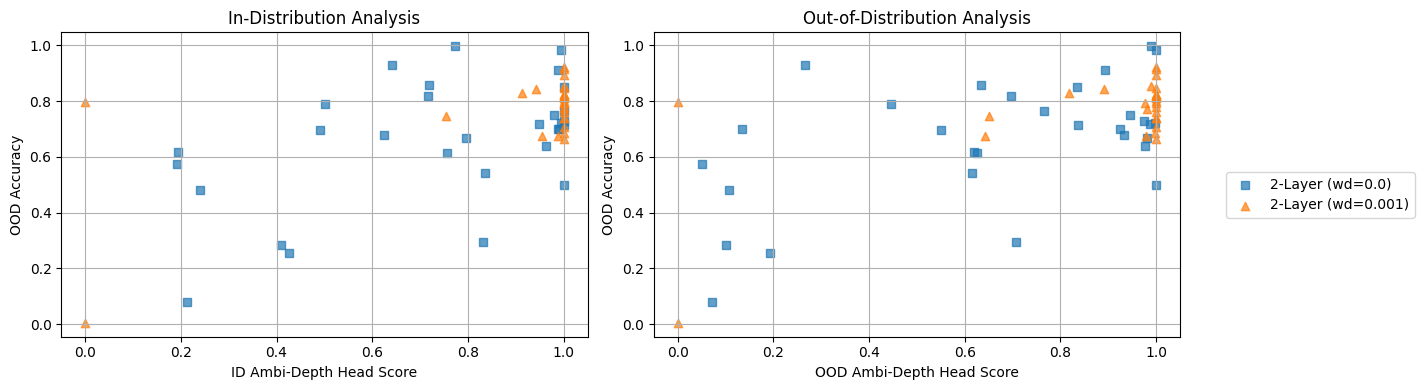

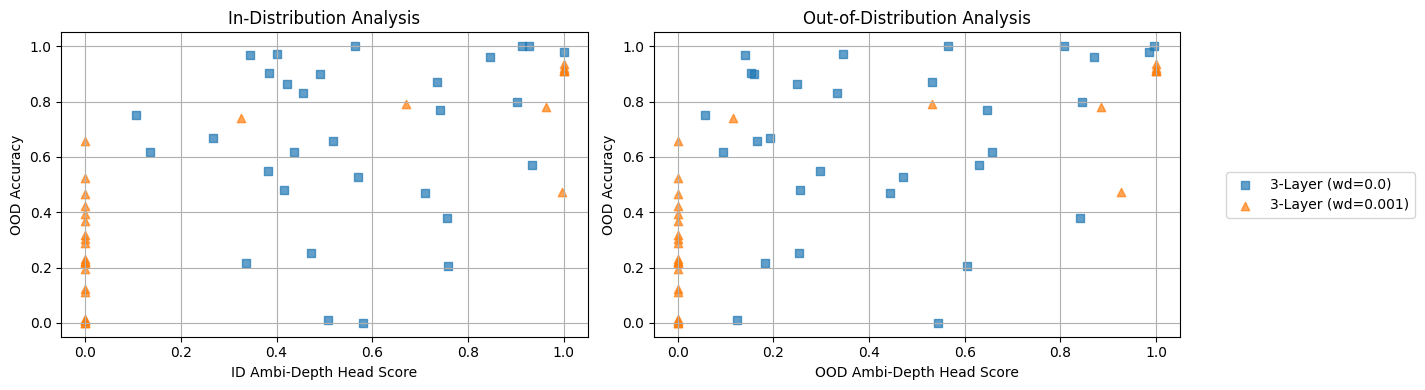

In [14]:
def plot_accuracy_vs_head_score(df, head_type="ambi", layer=None):
    """
    Plot OOD accuracy against head scores for both in-distribution and out-of-distribution data.
    For each model, plots its most impactful head's score.
    Points are shaped by weight decay: square for 0.0, triangle for 0.001, circle for 0.01
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Filter by layer if specified
    if layer is not None:
        df = df[df['n_layer'] == layer].copy()
    
    layers = df['n_layer'].unique()
    
    wd_markers = {
        0.0: 's',      # square
        0.001: '^',    # triangle
        0.01: 'o'      # circle
    }
    
    # Plot both distributions
    for ax, dist in zip([ax1, ax2], ['indist', 'ood']):
        for n_layer in layers:
            df_layer = df[df['n_layer'] == n_layer]
            
            # Plot for each weight decay value
            for wd, marker in wd_markers.items():
                mask = df_layer['wd'] == wd
                df_wd = df_layer[mask]
                
                if len(df_wd) == 0:
                    continue
                
                x_data = []
                y_data = []
                
                # For each model, find its most impactful head and get that head's score
                for idx, row in df_wd.iterrows():
                    head_key, impact = most_impactful_head(row, n_layer, 5, by_ood=True)
                    head_idx = int(head_key.split('_')[3])  # Don't subtract 1, heads are 1-indexed
                    
                    col = f'cp5_{head_type}_head_l{n_layer}_h{head_idx}_{dist}'
                    if col not in df_layer.columns:
                        continue
                    
                    x_data.append(row[col])
                    y_data.append(row['cp5_ood_acc'])
                
                if x_data:  # Only plot if we have data
                    ax.scatter(x_data, 
                             y_data,
                             alpha=0.7,
                             marker=marker,
                             label=f'{n_layer}-Layer (wd={wd})')
        
        head_type_name = names_short[head_type]
        ax.set_xlabel(f"{'OOD' if dist == 'ood' else 'ID'} {head_type_name} Head Score")
        ax.set_ylabel('OOD Accuracy')
        ax.grid(True, which="both", ls="-")
        # Only add legend to the second plot
        if dist == 'ood':
            handles, labels = ax.get_legend_handles_labels()
            fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left')
        ax.set_title(f"{'Out-of-Distribution' if dist == 'ood' else 'In-Distribution'} Analysis")
    
    plt.tight_layout()
    plt.show()

# Example usage:

df_wd0 = all_sweeps_df[all_sweeps_df['wd'] != 0.01]

# Plot OOD accuracy against "ambi" head scores for 2-layer models
plot_accuracy_vs_head_score(df_wd0, head_type="ambi", layer=2)
plot_accuracy_vs_head_score(df_wd0, head_type="ambi", layer=3)

In [26]:
def print_score_fractions(df, head_type, threshold=0.9):
    df2 = df[df['n_layer'] == 2]
    df3 = df[df['n_layer'] == 3]

    nonneg = [0] * 11
    neg = [0] * 11
    nonneg_neg_sum = [0] * 11
    for layer_num, df_layer in [(2, df2), (3, df3)]:
        for i, row in df_layer.iterrows():
            n_heads = row['n_head']
            # only consider head_type heads
            for head in range(n_heads):
                if row[f'cp5_{head_type}_head_l{layer_num}_h{head+1}_indist'] >= threshold:
                    nonneg_score = row[f'cp5_nonneg_head_l{layer_num}_h{head+1}_ood']
                    neg_score = row[f'cp5_neg_head_l{layer_num}_h{head+1}_ood']
                    nonneg[int(nonneg_score*10)] += 1
                    neg[int(neg_score*10)] += 1
                    nonneg_neg_sum[int((nonneg_score + neg_score)*10)] += 1
        print(f"Among ID {head_type} heads in {layer_num} layer models:")
        print(f"Nonneg. Depth OOD head score distribution: {nonneg}")
        print(f"Neg. Depth OOD head score distribution: {neg}")
        print(f"Sum of Nonneg. and Neg Depth OOD head scores distribution: {nonneg_neg_sum}")
        print("Normalized versions:")
        print(f"Nonneg. Depth OOD head score distribution: {[round(val/sum(nonneg), 2) for val in nonneg]}")
        print(f"Neg. Depth OOD head score distribution: {[round(val/sum(neg), 2) for val in neg]}")
        print(f"Sum of Nonneg. and Neg Depth OOD head scores distribution: {[round(val/sum(nonneg_neg_sum), 2) for val in nonneg_neg_sum]}")
        print()

print_score_fractions(all_sweeps_df, 'neg', threshold=0.7)


Among ID neg heads in 2 layer models:
Nonneg. Depth OOD head score distribution: [11, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Neg. Depth OOD head score distribution: [1, 0, 0, 0, 0, 0, 0, 0, 2, 7, 2]
Sum of Nonneg. and Neg Depth OOD head scores distribution: [0, 0, 0, 0, 0, 0, 0, 1, 2, 7, 2]
Normalized versions:
Nonneg. Depth OOD head score distribution: [0.92, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08, 0.0, 0.0, 0.0]
Neg. Depth OOD head score distribution: [0.08, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17, 0.58, 0.17]
Sum of Nonneg. and Neg Depth OOD head scores distribution: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08, 0.17, 0.58, 0.17]

Among ID neg heads in 3 layer models:
Nonneg. Depth OOD head score distribution: [18, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Neg. Depth OOD head score distribution: [1, 0, 0, 0, 0, 1, 0, 0, 4, 11, 2]
Sum of Nonneg. and Neg Depth OOD head scores distribution: [0, 0, 0, 0, 0, 1, 0, 1, 4, 11, 2]
Normalized versions:
Nonneg. Depth OOD head score distribution: [0.95, 0.0, 0.0, 0.0, 0.0,

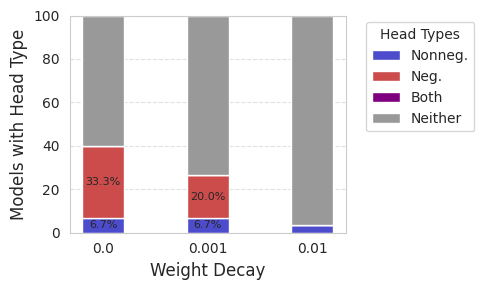

In [38]:
def stacked_bar_plot_wd(runs_df, threshold=0.5, n_layer = 2, head_types=['open', 'close', 'nonneg', 'neg']):
    plot_data = []
    head_types_extended = extend(head_types)
    checkpoint_ls = [5]
    wds = [0.0, 0.001, 0.01]
    for wd in wds:
        subset = runs_df[runs_df['wd'] == wd]
        for checkpoint in checkpoint_ls:
            counts = {cat: 0 for cat in head_types_extended}
            for _, row in subset.iterrows():
                assert row['n_layer'] == n_layer
                if has_head_type(row, 'nonneg', n_layer, checkpoint, threshold=threshold, indist_or_ood='ood') and has_head_type(row, 'neg', n_layer, checkpoint, threshold=threshold, indist_or_ood='ood'):
                    counts['both nonneg and neg'] += 1
                elif has_head_type(row, 'open', n_layer, checkpoint, threshold=threshold, indist_or_ood='ood') and has_head_type(row, 'close', n_layer, checkpoint, threshold=threshold, indist_or_ood='ood'):
                    counts['both open and close'] += 1
                else:
                    for cat in head_types:
                        if has_head_type(row, cat, n_layer, checkpoint, threshold=threshold, indist_or_ood='ood'):
                            counts[cat] += 1
                            break
                    else:
                        counts['none of the above'] += 1
            
            percentages = {cat: (count / len(subset) * 100) for cat, count in counts.items()}
            
            plot_data.append({
                'wd': wd,
                'Checkpoint': f"Checkpoint {checkpoint}",
                **percentages
            })

    df = pd.DataFrame(plot_data)

    # Set up the plot
    fig, ax = plt.subplots(figsize=(5, 3))

    # Create the stacked bar plot
    bar_width = 0.8
    index = np.arange(len(df['wd'].unique())) * (1 + len(checkpoint_ls))
    
    for i, checkpoint in enumerate(checkpoint_ls):
        bottom = np.zeros(len(df['wd'].unique()))
        subset = df[df['Checkpoint'] == f"Checkpoint {checkpoint}"].sort_values('wd')
        
        for category in head_types_extended:
            values = subset[category].fillna(0).values
            ax.bar(index + i*bar_width, values, bar_width, bottom=bottom, 
                   color=get_color_for(category), label=category if i == 0 else "")
            bottom += values

    # Customize the plot
    # ax.set_title(title, fontsize=16)
    ax.set_xlabel('Weight Decay', fontsize=12)
    ax.set_ylabel('Models with Head Type', fontsize=12)

    # Set x-axis labels
    ax.set_xticks(index + (len(checkpoint_ls) - 1)*bar_width / 2)
    ax.set_xticklabels([f"{wd}" for wd in wds])

    # Add percentage labels on the bars
    for i, (_, row) in enumerate(df.sort_values(['wd', 'Checkpoint']).iterrows()):
        cumulative = 0
        x_pos = index[i // len(checkpoint_ls)] + (i % len(checkpoint_ls)) * bar_width
        for category in head_types:
            height = row[category]
            if height > 5:  # Only show label if segment is large enough
                ax.text(x_pos, cumulative + height/2, f'{height:.1f}%', 
                        ha='center', va='center', fontsize=8)
            cumulative += height

    # Adjust legend
    names = {'open': 'Open-Bracket', 'close': 'Close-Bracket', 'nonneg': 'Nonneg.', 'neg': 'Neg.',
                'both open and close': 'Both Open and Close', 'both nonneg and neg': 'Both', 'none of the above': 'Neither'}
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    by_label = {names[x]: by_label[x] for x in head_types_extended}
    by_label = {k: by_label[k] for k in names.values() if 'Both' == k or '.' in k or 'Neither' in k}
    ax.legend(by_label.values(), by_label.keys(), title='Head Types', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add a subtle grid
    ax.grid(True, linestyle='--', alpha=0.6, axis='y')

    # Set y-axis to go from 0 to 100
    ax.set_ylim(0, 100)

    plt.tight_layout()
    plt.show()

df = all_sweeps_df
df = df[df['n_layer'] == 3]

stacked_bar_plot_wd(df, threshold=0.5, n_layer=3, head_types=['nonneg', 'neg'])

#todo: turn into pie charts or something? or show lengthwise? well for now just add it back into the paper

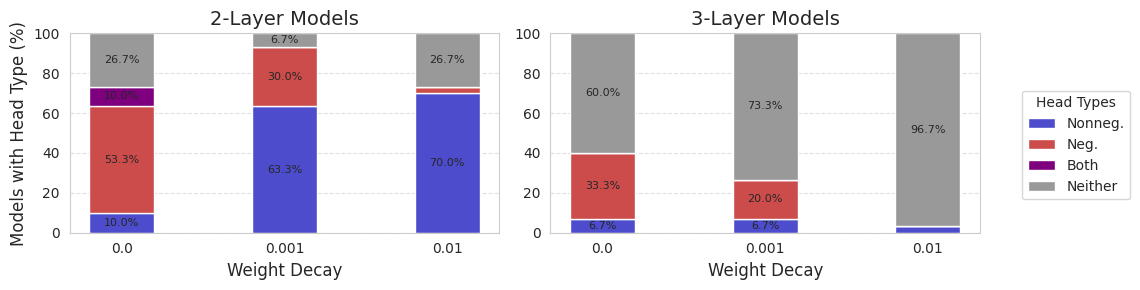

In [43]:
def stacked_bar_plot_wd(runs_df, threshold=0.5, head_types=['open', 'close', 'nonneg', 'neg']):
    plot_data = []
    head_types_extended = extend(head_types)
    checkpoint_ls = [5]
    wds = [0.0, 0.001, 0.01]
    n_layers = [2, 3]
    
    # Collect data for both layer counts
    for n_layer in n_layers:
        for wd in wds:
            subset = runs_df[runs_df['wd'] == wd]
            subset = subset[subset['n_layer'] == n_layer]
            
            for checkpoint in checkpoint_ls:
                counts = {cat: 0 for cat in head_types_extended}
                for _, row in subset.iterrows():
                    if has_head_type(row, 'nonneg', n_layer, checkpoint, threshold=threshold, indist_or_ood='ood') and has_head_type(row, 'neg', n_layer, checkpoint, threshold=threshold, indist_or_ood='ood'):
                        counts['both nonneg and neg'] += 1
                    elif has_head_type(row, 'open', n_layer, checkpoint, threshold=threshold, indist_or_ood='ood') and has_head_type(row, 'close', n_layer, checkpoint, threshold=threshold, indist_or_ood='ood'):
                        counts['both open and close'] += 1
                    else:
                        for cat in head_types:
                            if has_head_type(row, cat, n_layer, checkpoint, threshold=threshold, indist_or_ood='ood'):
                                counts[cat] += 1
                                break
                        else:
                            counts['none of the above'] += 1
                
                if len(subset) > 0:  # Avoid division by zero
                    percentages = {cat: (count / len(subset) * 100) for cat, count in counts.items()}
                else:
                    percentages = {cat: 0 for cat in counts}
                
                plot_data.append({
                    'wd': wd,
                    'n_layer': n_layer,
                    'Checkpoint': f"Checkpoint {checkpoint}",
                    **percentages
                })

    df = pd.DataFrame(plot_data)

    # Create side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    axes = {2: ax1, 3: ax2}

    # Plot for each number of layers
    for n_layer in n_layers:
        ax = axes[n_layer]
        df_layer = df[df['n_layer'] == n_layer]
        
        # Create the stacked bar plot
        bar_width = 0.8
        index = np.arange(len(wds)) * (1 + len(checkpoint_ls))
        
        for i, checkpoint in enumerate(checkpoint_ls):
            bottom = np.zeros(len(wds))
            subset = df_layer[df_layer['Checkpoint'] == f"Checkpoint {checkpoint}"].sort_values('wd')
            
            for category in head_types_extended:
                values = subset[category].fillna(0).values
                ax.bar(index + i*bar_width, values, bar_width, bottom=bottom, 
                       color=get_color_for(category), label=category if i == 0 and n_layer == 2 else "")
                bottom += values

        # Customize each subplot
        ax.set_xlabel('Weight Decay', fontsize=12)
        if n_layer == 2:  # Only add y-label to left plot
            ax.set_ylabel('Models with Head Type (%)', fontsize=12)
        
        # Set title for each subplot
        ax.set_title(f'{n_layer}-Layer Models', fontsize=14)

        # Set x-axis labels
        ax.set_xticks(index + (len(checkpoint_ls) - 1)*bar_width / 2)
        ax.set_xticklabels([f"{wd}" for wd in wds])

        # Add percentage labels on the bars
        for i, (_, row) in enumerate(df_layer.sort_values(['wd', 'Checkpoint']).iterrows()):
            cumulative = 0
            x_pos = index[i // len(checkpoint_ls)] + (i % len(checkpoint_ls)) * bar_width
            for category in head_types_extended:  # Changed from head_types to head_types_extended
                height = row[category]
                if height > 5:  # Only show label if segment is large enough
                    ax.text(x_pos, cumulative + height/2, f'{height:.1f}%', 
                            ha='center', va='center', fontsize=8)
                cumulative += height

        # Add a subtle grid
        ax.grid(True, linestyle='--', alpha=0.6, axis='y')

        # Set y-axis to go from 0 to 100
        ax.set_ylim(0, 100)

    # Add legend to the right of the figure with reduced spacing
    names = {'open': 'Open-Bracket', 'close': 'Close-Bracket', 'nonneg': 'Nonneg.', 'neg': 'Neg.',
            'both open and close': 'Both Open and Close', 'both nonneg and neg': 'Both', 'none of the above': 'Neither'}
    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    by_label = {names[x]: by_label[x] for x in head_types_extended}
    by_label = {k: by_label[k] for k in names.values() if 'Both' == k or '.' in k or 'Neither' in k}
    fig.legend(by_label.values(), by_label.keys(), title='Head Types', 
              bbox_to_anchor=(1.02, 0.5), loc='center left')  # Reduced from 1.05 to 1.02

    plt.tight_layout()
    plt.show()

# Example usage
df = all_sweeps_df
stacked_bar_plot_wd(df, threshold=0.5, head_types=['nonneg', 'neg'])